In [4]:
import openpyxl
import pandas as pd
from datetime import datetime

In [5]:


flowrate = pd.read_excel(r'Data-FlowRate.xlsx', header=1) 

In [6]:
flowrate.columns = ['raw_datetime','flow_Lpm'] 

flowrate.head(2)

,raw_datetime,flow_Lpm
0,2020-12-11T06:00:00+13:00,0.0
1,2020-12-11T06:01:00+13:00,0.0


### 2.1.3 Convert datetime string into Python datetime 

The datetime is in [ISO format](https://en.wikipedia.org/wiki/ISO_8601) and, because it includes the timezone, this is the most globally useful datetime format. 

> 2020-12-11T06:00:00+13:00 

where T indicates the time data and +13:00 is the time shift between UTC and New Zealand where the pumps were recording data. 

In [7]:
flowrate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   raw_datetime  711 non-null    object 
 1   flow_Lpm      711 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.2+ KB


Look at the output above and note that the _raw_datetime_ data type is _object_ and not _datetime_

We will use a two-step process to parse this date:

1. Convert it to a datetime object with the default UTC timezone
2. Convert the datetime object to local time in New Zealand so it can be combined with the pts tool data

In [8]:
# use a method that recognises the ISO format to parse the datetime

list = []
for date in flowrate['raw_datetime']:
    newdate = datetime.fromisoformat(date)
    list.append(newdate)
flowrate['ISO_datetime'] = list

flowrate.tail(2)

,raw_datetime,flow_Lpm,ISO_datetime
709,2020-12-11T17:59:00+13:00,0.0,2020-12-11 17:59:00+13:00
710,2020-12-11T18:00:00+13:00,0.0,2020-12-11 18:00:00+13:00


The method fromisoformate() is new in version Python 3.7

More information can be found [here](https://docs.python.org/3/library/datetime.html) and [here](https://pythontic.com/datetime/date/fromisoformat)

In [9]:
flowrate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   raw_datetime  711 non-null    object                   
 1   flow_Lpm      711 non-null    float64                  
 2   ISO_datetime  711 non-null    datetime64[ns, UTC+13:00]
dtypes: datetime64[ns, UTC+13:00](1), float64(1), object(1)
memory usage: 16.8+ KB


In [10]:
list = []
for date in flowrate.ISO_datetime:
    newdate = pd.to_datetime(datetime.strftime(date,'%Y-%m-%d %H:%M:%S'))
    list.append(newdate)
flowrate['datetime'] = list

flowrate.head()

,raw_datetime,flow_Lpm,ISO_datetime,datetime
0,2020-12-11T06:00:00+13:00,0.0,2020-12-11 06:00:00+13:00,2020-12-11 06:00:00
1,2020-12-11T06:01:00+13:00,0.0,2020-12-11 06:01:00+13:00,2020-12-11 06:01:00
2,2020-12-11T06:02:00+13:00,0.0,2020-12-11 06:02:00+13:00,2020-12-11 06:02:00
3,2020-12-11T06:03:00+13:00,0.0,2020-12-11 06:03:00+13:00,2020-12-11 06:03:00
4,2020-12-11T06:04:00+13:00,0.0,2020-12-11 06:04:00+13:00,2020-12-11 06:04:00


In [11]:
flowrate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   raw_datetime  711 non-null    object                   
 1   flow_Lpm      711 non-null    float64                  
 2   ISO_datetime  711 non-null    datetime64[ns, UTC+13:00]
 3   datetime      711 non-null    datetime64[ns]           
dtypes: datetime64[ns, UTC+13:00](1), datetime64[ns](1), float64(1), object(1)
memory usage: 22.3+ KB


Now we have a Python datetime object that we can combine with the PTS data which does not have timezone information.  

### 2.1.4 Add a flowrate field in our desired units

Conversions for typical geothermal flowrate units:

- L/sec to t/hr 3.6
- L/min to t/hr 0.060

In [12]:
flowrate['flow_tph'] = flowrate.flow_Lpm * 0.060

flowrate.head(2) # 23 to see the non-zero values

,raw_datetime,flow_Lpm,ISO_datetime,datetime,flow_tph
0,2020-12-11T06:00:00+13:00,0.0,2020-12-11 06:00:00+13:00,2020-12-11 06:00:00,0.0
1,2020-12-11T06:01:00+13:00,0.0,2020-12-11 06:01:00+13:00,2020-12-11 06:01:00,0.0


### 2.1.5 Trim excess columns from the dataframe

Now we just drop the columns that we don't want from the dataframe

In [13]:
flowrate.drop(columns = ['raw_datetime', 'flow_Lpm', 'ISO_datetime'], inplace = True)

flowrate.head(2)

,datetime,flow_tph
0,2020-12-11 06:00:00,0.0
1,2020-12-11 06:01:00,0.0


In [15]:
pts = pd.read_excel(r'Data-PTS.xlsx') 

In [16]:
pts.shape

(101294, 26)

In [17]:
pts.head(3)

,Date,Time,Timestamp,DEPTH,SPEED,Cable Weight,WHP,Temperature,Pressure,Frequency,...,SGS Voltage,Internal Temp 1,Internal Temp 2,Internal Temp 3,Cal Temp,Error Code 1,Error Code 2,Error Code 3,Records Saved,Bad Pages
0,yyyy-mm-dd,hh:mm:ss.sss,days,m,m/s,kg,barg,∞C,bara,Hz,...,V,∞C,∞C,∞C,∞C,Count,Count,Count,Count,Count
1,2020-12-11 00:00:00,00:26:44.800000,44176.39357,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0
2,2020-12-11 00:00:00,00:26:45,44176.39358,-6.32025,NaN,25.211151,-0.606777,19.68925,0.485864,41.483227,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0


In [20]:
# dictionary method for renaming some columns
dict = {
    'DEPTH':'depth_m',
    'SPEED': 'speed_mps',
    'Cable Weight': 'cweight_kg',
    'WHP': 'whp_barg',
    'Temperature': 'temp_degC',
    'Pressure': 'pressure_bara',
    'Frequency': 'frequency_hz'
}

pts.rename(columns=dict, inplace=True)

pts.head(3)

,Date,Time,Timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,...,SGS Voltage,Internal Temp 1,Internal Temp 2,Internal Temp 3,Cal Temp,Error Code 1,Error Code 2,Error Code 3,Records Saved,Bad Pages
0,yyyy-mm-dd,hh:mm:ss.sss,days,m,m/s,kg,barg,∞C,bara,Hz,...,V,∞C,∞C,∞C,∞C,Count,Count,Count,Count,Count
1,2020-12-11 00:00:00,00:26:44.800000,44176.39357,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0
2,2020-12-11 00:00:00,00:26:45,44176.39358,-6.32025,NaN,25.211151,-0.606777,19.68925,0.485864,41.483227,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0


### 2.2.3 Drop units row

Note that we are using the index value to drop the row of units and then we remake the index. Therefore, if we run this cell over and over, it will keep dropping the first row of data. 

If you are unsure what state your dataframe is in or how many times you have run the cell below, it is useful to run the process from the start again (i.e., go back to step _2.1.1 Import pts data using Pandas_ and work down from there). 

In [21]:
# drop units row using the index value of that row
pts.drop(0, inplace=True)

# re-index the dataframe
pts.reset_index(drop=True, inplace=True)

# WARNING if you run this cell again, it will drop the first line of data

In [22]:
pts.head(2)

,Date,Time,Timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,...,SGS Voltage,Internal Temp 1,Internal Temp 2,Internal Temp 3,Cal Temp,Error Code 1,Error Code 2,Error Code 3,Records Saved,Bad Pages
0,2020-12-11 00:00:00,00:26:44.800000,44176.39357,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0
1,2020-12-11 00:00:00,00:26:45,44176.39358,-6.32025,NaN,25.211151,-0.606777,19.68925,0.485864,41.483227,...,0,24.999414,24.999414,21.8269,0,0,0,0,7948034,0


In [23]:

wb = openpyxl.load_workbook(filename=r'Data-PTS.xlsx')

if wb.epoch == openpyxl.utils.datetime.CALENDAR_WINDOWS_1900: 
    print("This workbook is using the 1900 date system.")
if wb.epoch == openpyxl.utils.datetime.CALENDAR_MAC_1904: 
    print("This workbook is using the 1904 date system.")


This workbook is using the 1900 date system.


In [24]:
list = []
for date in pts.Timestamp:
    newdate = openpyxl.utils.datetime.from_excel(date)
    list.append(newdate)
pts['datetime'] = list

In [25]:
pts.head(3)

,Date,Time,Timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,...,Internal Temp 1,Internal Temp 2,Internal Temp 3,Cal Temp,Error Code 1,Error Code 2,Error Code 3,Records Saved,Bad Pages,datetime
0,2020-12-11 00:00:00,00:26:44.800000,44176.39357,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,...,24.999414,24.999414,21.8269,0,0,0,0,7948034,0,2020-12-11 09:26:44.448
1,2020-12-11 00:00:00,00:26:45,44176.39358,-6.32025,NaN,25.211151,-0.606777,19.68925,0.485864,41.483227,...,24.999414,24.999414,21.8269,0,0,0,0,7948034,0,2020-12-11 09:26:45.312
2,2020-12-11 00:00:00,00:26:45.200000,44176.39358,-6.32025,NaN,24.981985,-0.606582,19.69439,0.475091,42.96333,...,24.999414,24.999414,21.8269,0,0,0,0,7948034,0,2020-12-11 09:26:45.312


In [26]:
pts.columns

Index(['Date', 'Time', 'Timestamp', 'depth_m', 'speed_mps', 'cweight_kg',
       'whp_barg', 'temp_degC', 'pressure_bara', 'frequency_hz', 'Reed 0',
       'Reed 1', 'Reed 2', 'Reed 3', 'Battery Voltage', 'PRT Ref Voltage',
       'SGS Voltage', 'Internal Temp 1', 'Internal Temp 2', 'Internal Temp 3',
       'Cal Temp', 'Error Code 1', 'Error Code 2', 'Error Code 3',
       'Records Saved', 'Bad Pages', 'datetime'],
      dtype='object')

In [27]:
pts.drop(columns = ['Date', 'Time', 'Timestamp','Reed 0',
       'Reed 1', 'Reed 2', 'Reed 3', 'Battery Voltage', 
       'PRT Ref Voltage','SGS Voltage', 'Internal Temp 1', 
       'Internal Temp 2', 'Internal Temp 3','Cal Temp', 
       'Error Code 1', 'Error Code 2', 'Error Code 3',
       'Records Saved', 'Bad Pages',], inplace = True)

In [28]:
pts.head(3)

,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,datetime
0,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,2020-12-11 09:26:44.448
1,-6.32025,NaN,25.211151,-0.606777,19.68925,0.485864,41.483227,2020-12-11 09:26:45.312
2,-6.32025,NaN,24.981985,-0.606582,19.69439,0.475091,42.96333,2020-12-11 09:26:45.312


In [29]:
pts.dtypes

depth_m                  object
speed_mps                object
cweight_kg               object
whp_barg                 object
temp_degC                object
pressure_bara            object
frequency_hz             object
datetime         datetime64[ns]
dtype: object

In [30]:
pts[
    ['depth_m', 'speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
] = pts[
    ['depth_m','speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
    ].apply(pd.to_numeric)

pts.dtypes

depth_m                 float64
speed_mps               float64
cweight_kg              float64
whp_barg                float64
temp_degC               float64
pressure_bara           float64
frequency_hz            float64
datetime         datetime64[ns]
dtype: object

In [31]:
pts.columns

Index(['depth_m', 'speed_mps', 'cweight_kg', 'whp_barg', 'temp_degC',
       'pressure_bara', 'frequency_hz', 'datetime'],
      dtype='object')

In [32]:
def timedelta_seconds(dataframe_col, test_start):
    '''
    Make a float in seconds since the start of the test

    args:   dataframe_col: dataframe column containing datetime objects
            test_start: test start time formatted '2020-12-11 09:00:00'

    returns: float in seconds since the start of the test
    '''
    test_start_datetime = pd.to_datetime(test_start)
    list = []
    for datetime in dataframe_col:
        time_delta = datetime - test_start_datetime
        seconds = time_delta.total_seconds()
        list.append(seconds)
    return list

test_start_datetime = '2020-12-11 09:26:44.448'

flowrate['timedelta_sec'] = timedelta_seconds(flowrate.datetime, test_start_datetime)
pts['timedelta_sec'] = timedelta_seconds(pts.datetime, test_start_datetime)


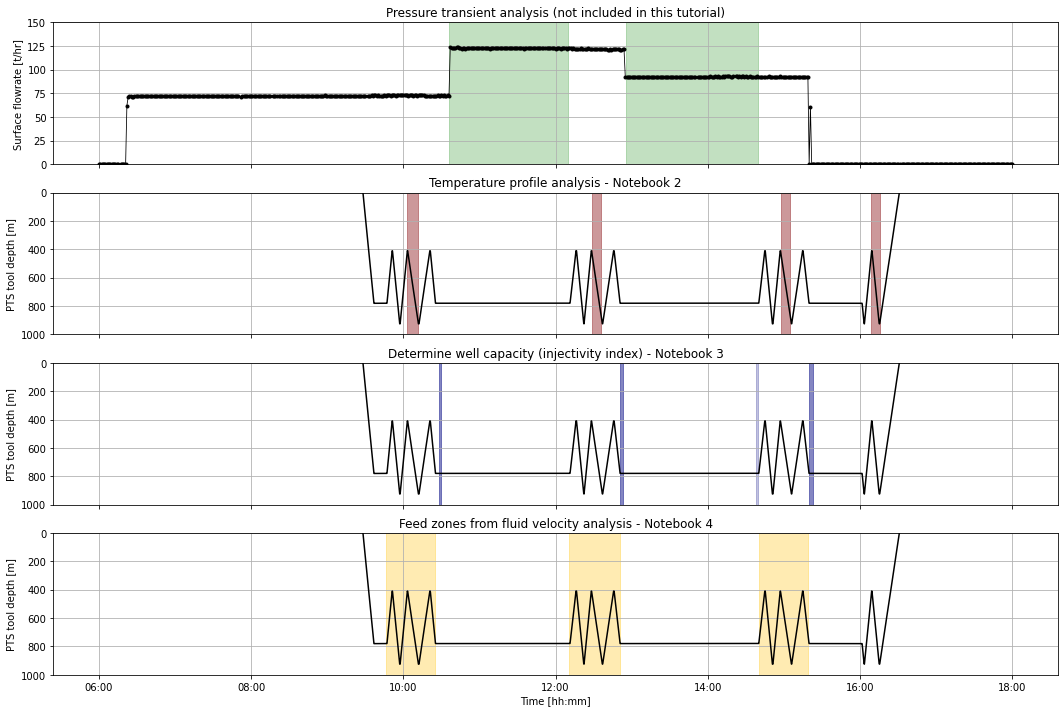

In [33]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,figsize=(18,12),sharex=True)

ax1.plot(flowrate.datetime, flowrate.flow_tph, label='Surface pump flowrate', 
    c='k', linewidth=0.8, marker='.')
ax1.set_ylabel('Surface flowrate [t/hr]')
ax1.set_ylim(0,150)

for ax in [ax2, ax3, ax4]:
    ax.plot(pts.datetime, pts.depth_m, label='PTS tool depth', 
        c='k', linewidth=1.5)
    ax.set_ylabel('PTS tool depth [m]')
    ax.set_ylim(1000,0)

ax4.set_xlabel('Time [hh:mm]')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
 
injectivity_index = [ # purple
    (pd.to_datetime('2020-12-11 10:28:00'),pd.to_datetime('2020-12-11 10:30:00')),
    (pd.to_datetime('2020-12-11 12:51:00'),pd.to_datetime('2020-12-11 12:53:00')),
    (pd.to_datetime('2020-12-11 15:20:00'),pd.to_datetime('2020-12-11 15:23:00')), # pumps shut off too soon
    ]
injectivity_index_alt = [ # light purple 
    (pd.to_datetime('2020-12-11 14:38:00'),pd.to_datetime('2020-12-11 14:40:00')) # alternate used because of pump issue
    ]
pressure_transient = [ # green
    (pd.to_datetime('2020-12-11 10:36:00'),pd.to_datetime('2020-12-11 12:10:00')),
    (pd.to_datetime('2020-12-11 12:55:15'),pd.to_datetime('2020-12-11 14:40:00')), 
    ]
temperature_profile = [ # red
    (pd.to_datetime('2020-12-11 10:03:00'),pd.to_datetime('2020-12-11 10:11:30')),
    (pd.to_datetime('2020-12-11 12:28:30'),pd.to_datetime('2020-12-11 12:36:00')),
    (pd.to_datetime('2020-12-11 14:57:30'),pd.to_datetime('2020-12-11 15:05:00')),
    (pd.to_datetime('2020-12-11 16:09:00'),pd.to_datetime('2020-12-11 16:15:30'))
    ]
fluid_velocity = [ # yellow
    (pd.to_datetime('2020-12-11 09:46:00'),pd.to_datetime('2020-12-11 10:25:00')),
    (pd.to_datetime('2020-12-11 12:10:30'),pd.to_datetime('2020-12-11 12:51:00')),
    (pd.to_datetime('2020-12-11 14:40:30'),pd.to_datetime('2020-12-11 15:19:00')),
    ]

ax1.set_title('Pressure transient analysis (not included in this tutorial)')
for top, bottom in pressure_transient:
    ax1.axvspan(top, bottom, color='#369a33', alpha=0.3) # green

ax2.set_title('Temperature profile analysis - Notebook 2')
for top, bottom in temperature_profile:
    ax2.axvspan(top, bottom, color='#9a3336', alpha = 0.5) # red 

ax3.set_title('Determine well capacity (injectivity index) - Notebook 3')
for top, bottom in injectivity_index:
    ax3.axvspan(top, bottom, color='#33369a', alpha=.6) # purple

for top, bottom in injectivity_index_alt:
    ax3.axvspan(top, bottom, color='#33369a', alpha=.3) # light purple
    
ax4.set_title('Feed zones from fluid velocity analysis - Notebook 4')
for top, bottom in fluid_velocity:
    ax4.axvspan(top, bottom, color='#ffc000', alpha=.3) # yellow 

for ax in [ax1, ax2, ax3, ax4]:
    ax.grid()
 
plt.show();

#### Overview of the completion test (plot above)

The highlighted areas on the plot above are the data we will extract for analysis during this tutorial. 

The zig-zags in the PTS tool depth show the tool going up and down inside the well. Injectivity index (well capacity) uses pressure and flow rate just after these tool passes are complete and before the pump rate is changed (dark purple). However, after the third set of passes (i.e., during the third flowrate) the pumps were shut off too soon, so we will use the pressure and flow rate just prior to the passes (light purple).

#### Use the plot below to explore the entire dataset

In [34]:
def overview_fig(pts_df,flowrate_df,title=''):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1,figsize=(10,15),sharex=True)
    ax1.set_title(title,y=1.1,fontsize=15)

    ax1.plot(flowrate_df.datetime, flowrate_df.flow_tph, label='Surface pump flowrate', 
        c='k', linewidth=0.8, marker='.')
    ax1.set_ylabel('Surface flowrate [t/hr]')
    ax1.set_ylim(0,150)
    
    ax2.plot(pts_df.datetime, pts_df.depth_m, label='PTS tool depth', 
        c='k', linewidth=0.8)
    ax2.set_ylabel('PTS tool depth [m]')
    ax2.set_ylim(1000,0)
    
    ax3.plot(pts_df.datetime, pts_df.pressure_bara, label='PTS pressure', 
        c='tab:blue', linewidth=0.8)
    ax3.set_ylabel('PTS pressure [bara]')
    
    ax4.plot(pts_df.datetime, pts_df.temp_degC, label='PTS temperature', 
        c='tab:red', linewidth=0.8)
    ax4.set_ylabel('PTS temperature')
    
    ax5.plot(pts_df.datetime, pts_df.frequency_hz, label='PTS impeller frequency', 
        c='tab:green', linewidth=0.8)
    ax5.set_ylim(-30,30)
    ax5.set_ylabel('PTS impeller frequency [hz]')
    # 1 hz = 60 rpm

    ax6.plot(pts_df.datetime, pts_df.speed_mps, label='PTS tool speed', 
        c='tab:orange', linewidth=0.8)
    ax6.set_ylim(-2,2)
    ax6.set_ylabel('PTS tool speed [mps]')
    
    ax6.set_xlabel('Time [hh:mm]')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
        ax.grid()
    
    return plt

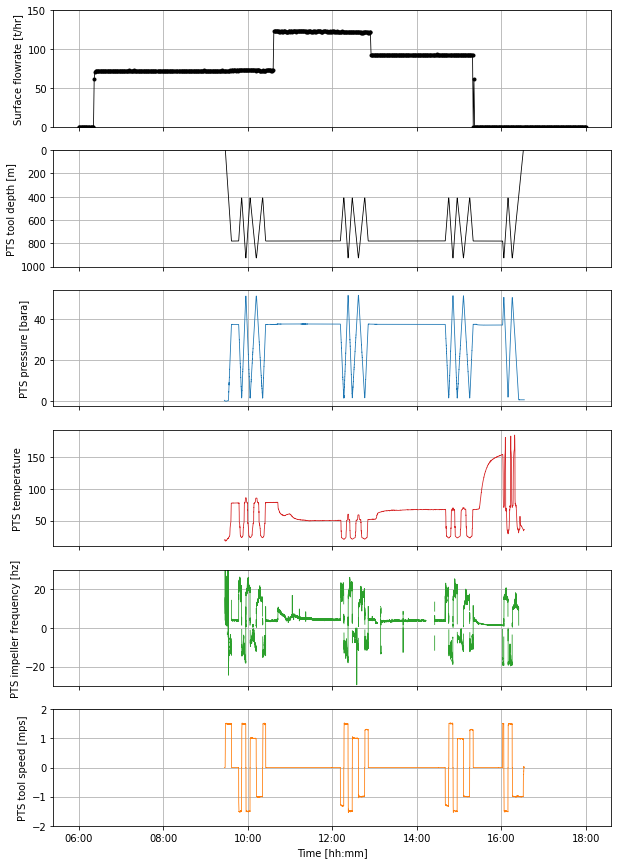

In [35]:
overview_fig(pts,flowrate);

Note that I sometimes use a ; at the end of the code in the cell to suppress extra output, as is has been done above.

*** negrito

###  references

Kaya, E., Zarrouk, S.J., and O’Sullivan, M.J. (2011): Reinjection in geothermal fields: a review of worldwide experience. Renew. Sustain. Energy Rev. 15 (1), 47-68. 

Zarrouk, S.J. and McLean, K. (2019): Geothermal well test analysis: fundamentals, applications, and advanced techniques. 1st edition, Elsevier. 

***

© 2021 [Irene Wallis](https://www.cubicearth.nz/) and [Katie McLean](https://www.linkedin.com/in/katie-mclean-25994315/) 

Licensed under the Apache License, Version 2.0


***